# Sección 4: Entrenamiento y Evaluación de Modelos

## Objetivo
Entrenar 6 modelos distintos × 3 estrategias de datos = 18 modelos totales.
Comparar qué estrategia (Baseline vs FE vs FE+SMOTE) mejora más el F1-Score.

## Configuración Experimental

**Split de datos:**
- Train (60%): Entrenamiento + GridSearchCV 5-fold
- Val (20%): Selección de mejor modelo
- Test (20%): Evaluación final

**Balanceo de clases:**
- Baseline: class_weight='balanced'
- FE: class_weight='balanced'
- FE+SMOTE: SMOTE en train (sin class_weight, ya 50/50)

**Búsqueda de hiperparámetros:**
- GridSearchCV con CV estratificado 5-fold
- Scoring: F1-Score
- Mismos hyperparams para las 3 estrategias (comparación justa)
- XGBoost acelerado en GPU (NVIDIA RTX 3090)

## Modelos Evaluados

| Modelo | Tipo | Justificación |
|--------|------|---|
| **Logistic Regression** | Paramétrico (discriminante gausiano/regresión) | Baseline lineal, interpretable |
| **k-NN** | No-paramétrico | Busca patrones locales sin asumir forma |
| **Random Forest** | Ensemble de árboles | Robusto, maneja no-linealidades |
| **MLP** | Red neuronal artificial | Captura interacciones complejas |
| **XGBoost** | Ensemble boosting | State-of-the-art, árboles gradualmente mejorados |
| **SVM** | Máquina de vectores soporte | Separación no-lineal (kernel RBF) |

## Métricas de Desempeño

**Principal: F1-Score** → balance entre precision y recall (importante en desbalance 70/30)

**Secundarias:**
- Precision: evitar falsos positivos (clientes inactivos que no dejan)
- Recall: evitar falsos negativos (clientes churn que no detectamos)
- ROC-AUC: capacidad de discriminación
- Accuracy: métrica complementaria

Se reportan en train/val/test para detectar overfitting.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Fix para MKL error en Windows
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE

# Validación y métricas
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    roc_auc_score, roc_curve, confusion_matrix,
    classification_report, ConfusionMatrixDisplay
)

import warnings
warnings.filterwarnings('ignore')

def print_section(title):
    display(Markdown(f"### {title}"))
    display(Markdown('---'))

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 4.1 Cargar Todas las Versiones de Datos

In [2]:
print_section("Carga de TODAS las Versiones de Datos")

with open('data/train_data.pkl', 'rb') as f:
    train_baseline = pickle.load(f)
with open('data/val_data.pkl', 'rb') as f:
    val_baseline = pickle.load(f)
with open('data/test_data.pkl', 'rb') as f:
    test_baseline = pickle.load(f)

with open('data/train_data_fe.pkl', 'rb') as f:
    train_fe = pickle.load(f)
with open('data/val_data_fe.pkl', 'rb') as f:
    val_fe = pickle.load(f)
with open('data/test_data_fe.pkl', 'rb') as f:
    test_fe = pickle.load(f)

with open('data/train_data_fe_smote.pkl', 'rb') as f:
    train_fe_smote = pickle.load(f)
# Val y Test son los mismos que FE sin SMOTE

# Resumen de todas las estrategias
strategies_summary = pd.DataFrame({
    'Estrategia': ['Baseline (sin FE)', 'FE sin SMOTE', 'FE + SMOTE'],
    'Train_samples': [len(train_baseline['y']), len(train_fe['y']), len(train_fe_smote['y'])],
    'Val_samples': [len(val_baseline['y']), len(val_fe['y']), len(val_fe['y'])],
    'Test_samples': [len(test_baseline['y']), len(test_fe['y']), len(test_fe['y'])],
    'Features': [len(train_baseline['columns']), len(train_fe['columns']), len(train_fe_smote['columns'])],
    'Train_Churn_%': [
        f"{(train_baseline['y'] == 1).mean()*100:.1f}%",
        f"{(train_fe['y'] == 1).mean()*100:.1f}%",
        f"{(train_fe_smote['y'] == 1).mean()*100:.1f}%"
    ]
})

display(Markdown("**✓ Todas las versiones cargadas correctamente:**"))
display(strategies_summary)

### Carga de TODAS las Versiones de Datos

---

**✓ Todas las versiones cargadas correctamente:**

,Estrategia,Train_samples,Val_samples,Test_samples,Features,Train_Churn_%
0,Baseline (sin FE),4800,1600,1600,20,25.9%
1,FE sin SMOTE,4800,1600,1600,34,25.9%
2,FE + SMOTE,7114,1600,1600,34,50.0%


Observemos cómo nuestro **FE+Smote** Tiene un porcentaje de valores con churn del 50% dado que anteriormente aplicamos **sobremeustreo**

## 4.2 Configuración Experimental

### 4.2.1 Metodología de Validación

- **Estrategia**: Validación cruzada estratificada con **5-fold CV** sobre el conjunto de entrenamiento.
- **Balanceo de clases**: 
  - **Baseline y FE**: `class_weight='balanced'` en modelos compatibles (Logistic Regression, Random Forest, SVM). XGBoost usa `scale_pos_weight=2.33`.
  - **FE + SMOTE**: Sin `class_weight` (redundante, ya balanceado con SMOTE). XGBoost usa `scale_pos_weight=1`.
- **Búsqueda de hiperparámetros**: GridSearchCV con scoring basado en **F1-Score**.
- **Evaluación final**: Modelos entrenados en train, evaluados en val y test.

### 4.2.2 Métricas de Desempeño

| Métrica | Justificación |
|---------|---------------|
| **F1-Score** | Métrica principal: balance entre precisión y recall en datasets desbalanceados (70/30) |
| **Precision** | Proporción de predicciones positivas correctas (evitar falsos positivos) |
| **Recall** | Proporción de casos positivos detectados (evitar falsos negativos) |
| **ROC-AUC** | Capacidad de discriminación entre clases, independiente del umbral |
| **Accuracy** | Métrica complementaria (menos relevante en desbalance) |

### 4.2.3 Hiperparámetros y Mallas de Búsqueda (IDÉNTICAS PARA LAS 3 ESTRATEGIAS)

In [3]:
print_section("Definición de Mallas de Hiperparámetros (Ultra-Rápida & Regularizada)")

param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear'],
        'class_weight': ['balanced']
    },
    'k-NN': {
        'n_neighbors': [5, 10, 35, 50],         
        'weights': ['distance', 'uniform'], # Necesario para probar ambas estrategias
        'metric': ['manhattan']
    },
    'Random Forest': {
        'n_estimators': [150],
        'max_depth': [5, 10],            # Profundidad controlada
        'min_samples_split': [20],
        'min_samples_leaf': [10, 20],    # Hojas robustas
        'max_features': ['sqrt'],
        'class_weight': ['balanced', None]
    },
    'MLP Neural Network': {
        'hidden_layer_sizes': [(100, 50)],
        'activation': ['relu'],
        'solver': ['adam'],
        'alpha': [0.01],                 # Regularización fija
        'learning_rate': ['adaptive'],
        'max_iter': [500]
    },
    'XGBoost': {
        'n_estimators': [150],
        'max_depth': [3, 5],             # Profundidad baja/media
        'learning_rate': [0.05],         # LR conservador
        'subsample': [0.8],
        'scale_pos_weight': [1, 2],      # Balanceo
        'min_child_weight': [5],
        'reg_lambda': [10, 20],          # Regularización L2 fuerte
        'max_delta_step': [1]            # Control de actualizaciones para estabilidad
    },
    'SVM': {
        'C': [1, 10],
        'kernel': ['rbf'],
        'gamma': ['scale'],
        'class_weight': ['balanced']
    }
}

total_combos = {}
for model_name, grid in param_grids.items():
    n_combos = np.prod([len(v) for v in grid.values()])
    total_combos[model_name] = int(n_combos)

display(Markdown("**Malla de Hiperparámetros (Versión Rápida):**\n"))
summary_df = pd.DataFrame(list(total_combos.items()), columns=['Modelo', 'Combinaciones'])
summary_df = summary_df.sort_values('Combinaciones', ascending=False)
display(summary_df)
total_all = summary_df['Combinaciones'].sum()

display(Markdown(f"**Total de combinaciones a evaluar:** {total_all:,} (vs >300 antes)"))
display(Markdown("⚡ **Optimización:** Se han fijado parámetros robustos para reducir drásticamente el tiempo de búsqueda sin sacrificar regularización."))

### Definición de Mallas de Hiperparámetros (Ultra-Rápida & Regularizada)

---

**Malla de Hiperparámetros (Versión Rápida):**


,Modelo,Combinaciones
1,k-NN,8
2,Random Forest,8
4,XGBoost,8
0,Logistic Regression,3
5,SVM,2
3,MLP Neural Network,1


**Total de combinaciones a evaluar:** 30 (vs >300 antes)

⚡ **Optimización:** Se han fijado parámetros robustos para reducir drásticamente el tiempo de búsqueda sin sacrificar regularización.

**Elección de 5‑fold CV**

- **Trade‑off bias/varianza:** k=5 es un buen compromiso para conjuntos de tamaño medio: reduce el sesgo respecto a muy pocos folds y evita el coste y la varianza alta de folds muy grandes
- **Coste computacional:** con mallas grandes y modelos costosos (XGBoost, MLP) 5‑fold mantiene el tiempo de GridSearchCV en un rango razonable.
- **Estratificación:** usamos `StratifiedKFold` para mantener la proporción churn/no‑churn (~70/30) en cada fold y evitar estimaciones sesgadas por folds atípicos.


- Solo lo usamos para aquellos que no tienen SMOTE, ya que al que tiene este último, podría afectar la validación

In [4]:
# Mostrar tamaño de train y tamaño aproximado de cada fold (ayuda a decidir k)
n_splits = 5
n_train_baseline = len(train_baseline['y'])
fold_size = n_train_baseline // n_splits
print(f"Train total samples (baseline): {n_train_baseline}")
print(f"Using {n_splits}-fold CV -> approx. {fold_size} samples per validation fold (~{fold_size/n_train_baseline:.2%})")
print("Class balance in train (churn %):")
print(f"  Churn: {(np.array(train_baseline['y'])==1).mean()*100:.2f}%")

Train total samples (baseline): 4800
Using 5-fold CV -> approx. 960 samples per validation fold (~20.00%)
Class balance in train (churn %):
  Churn: 25.90%


## 4.3 Entrenamiento de Modelos (3 Estrategias × 6 Modelos = 18 Entrenamientos)

In [5]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def train_strategy(X_train, y_train, strategy_name, use_class_weight=True, use_cv=True, use_holdout_search=False, X_val_holdout=None, y_val_holdout=None):
    """Entrena los 6 modelos para una estrategia dada
    
    Args:
        X_train: Features de entrenamiento
        y_train: Target de entrenamiento
        strategy_name: Nombre de la estrategia
        use_class_weight: Si usar class_weight='balanced'
        use_cv: Si usar k-fold CV (True para Baseline/FE)
        use_holdout_search: Si usar búsqueda con holdout set (True para SMOTE, evita leakage)
        X_val_holdout: Features de validación (opcional, para validar contra datos reales en SMOTE)
        y_val_holdout: Target de validación (opcional)
    """

    # Modelos base
    base_models = {
        'Logistic Regression': LogisticRegression(
            random_state=RANDOM_STATE, 
            class_weight='balanced' if use_class_weight else None, 
            max_iter=1000
        ),
        'k-NN': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(
            random_state=RANDOM_STATE, 
            class_weight='balanced' if use_class_weight else None, 
            n_jobs=2  # Reducir para evitar memoria excesiva
        ),
        'MLP Neural Network': MLPClassifier(
            random_state=RANDOM_STATE, 
            early_stopping=True, 
            max_iter=500, 
            n_iter_no_change=10
        ),
        'XGBoost': XGBClassifier(
            random_state=RANDOM_STATE, 
            eval_metric='logloss', 
            scale_pos_weight=2.33 if use_class_weight else 1,
            tree_method='hist',
            device='cuda:0'
        ),
        'SVM': SVC(
            random_state=RANDOM_STATE, 
            probability=True, 
            class_weight='balanced' if use_class_weight else None
        )
    }

    trained_models = {}
    cv_results = {}

    # Decidir estrategia de validación
    if use_holdout_search:
        if X_val_holdout is not None:
            cv_info = "Holdout GridSearch (Train=SMOTE, Val=REAL)"
        else:
            cv_info = "Holdout GridSearch (80/20 split interno)"
    elif use_cv:
        cv_info = "5-fold CV"
    else:
        cv_info = "Sin búsqueda (hiperparams por defecto)"
    
    display(Markdown(f"\n###  Entrenando: **{strategy_name}** ({cv_info})"))
    display(Markdown(f"class_weight={'balanced' if use_class_weight else 'None'} | XGBoost scale_pos_weight={2.33 if use_class_weight else 1}"))

    # Si usamos holdout search, crear split interno
    if use_holdout_search:
        if X_val_holdout is not None and y_val_holdout is not None:
            # Usar validación explícita (REAL) para evitar validar con datos sintéticos
            X_train_inner = X_train
            y_train_inner = y_train
            X_val_inner = X_val_holdout
            y_val_inner = y_val_holdout
            display(Markdown(" Usando set de validación explícito (REAL) para optimización."))
        else:
            from sklearn.model_selection import train_test_split
            X_train_inner, X_val_inner, y_train_inner, y_val_inner = train_test_split(
                X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
            )
        
        # Crear índices para PredefinedSplit (simula un solo fold con train/val fijos)
        test_fold = np.concatenate([
            np.full(len(y_train_inner), -1),  # Train indices
            np.zeros(len(y_val_inner))        # Val indices (fold 0)
        ])
        from sklearn.model_selection import PredefinedSplit
        ps = PredefinedSplit(test_fold)
        X_train_combined = np.vstack([X_train_inner, X_val_inner])
        y_train_combined = np.concatenate([y_train_inner, y_val_inner])

    for model_name in base_models.keys():
        display(Markdown(f"  ⏳ {model_name}..."))

        if use_cv or use_holdout_search:
            # GridSearchCV con k-fold CV o holdout set
            # Reducir n_jobs para evitar TerminatedWorkerError por falta de memoria
            if model_name == 'XGBoost':
                n_jobs_cv = 1
            elif model_name in ['Random Forest', 'MLP Neural Network']:
                n_jobs_cv = 2
            else:
                n_jobs_cv = 4

            grid_search = GridSearchCV(
                estimator=base_models[model_name],
                param_grid=param_grids[model_name],
                cv=ps if use_holdout_search else cv_strategy,
                scoring='f1',
                n_jobs=n_jobs_cv,
                verbose=1,
                return_train_score=True
            )

            if use_holdout_search:
                grid_search.fit(X_train_combined, y_train_combined)
            else:
                grid_search.fit(X_train, y_train)

            trained_models[model_name] = grid_search.best_estimator_
            cv_results[model_name] = {
                'best_params': grid_search.best_params_,
                'best_score': grid_search.best_score_
            }

            # Mostrar mejores hiperparámetros de forma compacta
            params_str = ', '.join([f"{k}={v}" for k, v in grid_search.best_params_.items()])
            display(Markdown(f"     ✓ F1-Val: **{grid_search.best_score_:.4f}**"))
            display(Markdown(f"       Params: `{params_str}`"))
        else:
            # Entrenamiento directo sin búsqueda (no debería usarse ya)
            model = base_models[model_name]
            model.fit(X_train, y_train)

            trained_models[model_name] = model
            cv_results[model_name] = {
                'best_params': 'default (no search)',
                'best_score': None
            }

            display(Markdown(f"     ✓ Entrenado (hiperparámetros por defecto)"))

    return trained_models, cv_results



## Entrenamiento

In [6]:
all_trained_models = {}
all_cv_results = {}

# Estrategia 1: Baseline
models_baseline, cv_baseline = train_strategy(
    train_baseline['X'], train_baseline['y'],
    "Baseline (sin FE)",
    use_class_weight=True,
    use_cv=True
)
all_trained_models['Baseline'] = models_baseline
all_cv_results['Baseline'] = cv_baseline

# Estrategia 2: FE sin SMOTE
models_fe, cv_fe = train_strategy(
    train_fe['X'], train_fe['y'],
    "FE (con Feature Engineering, sin SMOTE)",
    use_class_weight=True,
    use_cv=True
)
all_trained_models['FE'] = models_fe
all_cv_results['FE'] = cv_fe

# Estrategia 3: FE + SMOTE 
models_fe_smote, cv_fe_smote = train_strategy(
    train_fe_smote['X'], train_fe_smote['y'],
    "FE + SMOTE (con FE + SMOTE en train)",
    use_class_weight=False,  # SMOTE ya balanceó
    use_cv=False,
    use_holdout_search=True,  # Usar holdout para búsqueda
    X_val_holdout=val_fe['X'], # Validar contra datos REALES (sin SMOTE)
    y_val_holdout=val_fe['y']
)
all_trained_models['FE+SMOTE'] = models_fe_smote
all_cv_results['FE+SMOTE'] = cv_fe_smote

display(Markdown("**Nota:** FE+SMOTE usa GridSearch con holdout interno (Train=SMOTE, Val=REAL) para optimizar hiperparámetros sin data leakage."))
display(Markdown("\n*✓ 18 modelos entrenados (3 estrategias × 6 modelos)**"))


###  Entrenando: **Baseline (sin FE)** (5-fold CV)

class_weight=balanced | XGBoost scale_pos_weight=2.33

  ⏳ Logistic Regression...

Fitting 5 folds for each of 3 candidates, totalling 15 fits


     ✓ F1-Val: **0.3471**

       Params: `C=10, class_weight=balanced, penalty=l2, solver=liblinear`

  ⏳ k-NN...

Fitting 5 folds for each of 8 candidates, totalling 40 fits


     ✓ F1-Val: **0.1436**

       Params: `metric=manhattan, n_neighbors=5, weights=distance`

  ⏳ Random Forest...

Fitting 5 folds for each of 8 candidates, totalling 40 fits


     ✓ F1-Val: **0.2938**

       Params: `class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=150`

  ⏳ MLP Neural Network...

Fitting 5 folds for each of 1 candidates, totalling 5 fits


     ✓ F1-Val: **0.0000**

       Params: `activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, max_iter=500, solver=adam`

  ⏳ XGBoost...

Fitting 5 folds for each of 8 candidates, totalling 40 fits


     ✓ F1-Val: **0.1771**

       Params: `learning_rate=0.05, max_delta_step=1, max_depth=5, min_child_weight=5, n_estimators=150, reg_lambda=20, scale_pos_weight=2, subsample=0.8`

  ⏳ SVM...

Fitting 5 folds for each of 2 candidates, totalling 10 fits


     ✓ F1-Val: **0.3299**

       Params: `C=1, class_weight=balanced, gamma=scale, kernel=rbf`


###  Entrenando: **FE (con Feature Engineering, sin SMOTE)** (5-fold CV)

class_weight=balanced | XGBoost scale_pos_weight=2.33

  ⏳ Logistic Regression...

Fitting 5 folds for each of 3 candidates, totalling 15 fits


     ✓ F1-Val: **0.3477**

       Params: `C=0.1, class_weight=balanced, penalty=l2, solver=liblinear`

  ⏳ k-NN...

Fitting 5 folds for each of 8 candidates, totalling 40 fits


     ✓ F1-Val: **0.1452**

       Params: `metric=manhattan, n_neighbors=5, weights=distance`

  ⏳ Random Forest...

Fitting 5 folds for each of 8 candidates, totalling 40 fits


     ✓ F1-Val: **0.2977**

       Params: `class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=150`

  ⏳ MLP Neural Network...

Fitting 5 folds for each of 1 candidates, totalling 5 fits


     ✓ F1-Val: **0.0000**

       Params: `activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, max_iter=500, solver=adam`

  ⏳ XGBoost...

Fitting 5 folds for each of 8 candidates, totalling 40 fits


     ✓ F1-Val: **0.1802**

       Params: `learning_rate=0.05, max_delta_step=1, max_depth=5, min_child_weight=5, n_estimators=150, reg_lambda=10, scale_pos_weight=2, subsample=0.8`

  ⏳ SVM...

Fitting 5 folds for each of 2 candidates, totalling 10 fits


     ✓ F1-Val: **0.3246**

       Params: `C=1, class_weight=balanced, gamma=scale, kernel=rbf`


###  Entrenando: **FE + SMOTE (con FE + SMOTE en train)** (Holdout GridSearch (Train=SMOTE, Val=REAL))

class_weight=None | XGBoost scale_pos_weight=1

 Usando set de validación explícito (REAL) para optimización.

  ⏳ Logistic Regression...

Fitting 1 folds for each of 3 candidates, totalling 3 fits


     ✓ F1-Val: **0.3421**

       Params: `C=1, class_weight=balanced, penalty=l2, solver=liblinear`

  ⏳ k-NN...

Fitting 1 folds for each of 8 candidates, totalling 8 fits


     ✓ F1-Val: **0.3564**

       Params: `metric=manhattan, n_neighbors=35, weights=uniform`

  ⏳ Random Forest...

Fitting 1 folds for each of 8 candidates, totalling 8 fits


     ✓ F1-Val: **0.2475**

       Params: `class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=150`

  ⏳ MLP Neural Network...

Fitting 1 folds for each of 1 candidates, totalling 1 fits


     ✓ F1-Val: **0.3045**

       Params: `activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, max_iter=500, solver=adam`

  ⏳ XGBoost...

Fitting 1 folds for each of 8 candidates, totalling 8 fits


     ✓ F1-Val: **0.3670**

       Params: `learning_rate=0.05, max_delta_step=1, max_depth=3, min_child_weight=5, n_estimators=150, reg_lambda=20, scale_pos_weight=2, subsample=0.8`

  ⏳ SVM...

Fitting 1 folds for each of 2 candidates, totalling 2 fits


     ✓ F1-Val: **0.3187**

       Params: `C=1, class_weight=balanced, gamma=scale, kernel=rbf`

**Nota:** FE+SMOTE usa GridSearch con holdout interno (Train=SMOTE, Val=REAL) para optimizar hiperparámetros sin data leakage.


*✓ 18 modelos entrenados (3 estrategias × 6 modelos)**

## 4.4 Evaluación en Conjuntos Train/Val/Test (COMPARACIÓN ENTRE ESTRATEGIAS)

In [7]:
print_section("Evaluación Comparativa de las 3 Estrategias")

# Función para calcular métricas
def evaluate_model(model, X, y, dataset_name=''):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else None
    
    metrics = {
        'Dataset': dataset_name,
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred, zero_division=0),
        'Recall': recall_score(y, y_pred, zero_division=0),
        'F1-Score': f1_score(y, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y, y_proba) if y_proba is not None else np.nan
    }
    return metrics

# Evaluar todas las estrategias
all_results = []

# Estrategia 1: Baseline
for model_name, model in all_trained_models['Baseline'].items():
    train_metrics = evaluate_model(model, train_baseline['X'], train_baseline['y'], 'Train')
    val_metrics = evaluate_model(model, val_baseline['X'], val_baseline['y'], 'Val')
    test_metrics = evaluate_model(model, test_baseline['X'], test_baseline['y'], 'Test')
    
    for metrics in [train_metrics, val_metrics, test_metrics]:
        metrics['Model'] = model_name
        metrics['Strategy'] = 'Baseline'
        all_results.append(metrics)

# Estrategia 2: FE sin SMOTE
for model_name, model in all_trained_models['FE'].items():
    train_metrics = evaluate_model(model, train_fe['X'], train_fe['y'], 'Train')
    val_metrics = evaluate_model(model, val_fe['X'], val_fe['y'], 'Val')
    test_metrics = evaluate_model(model, test_fe['X'], test_fe['y'], 'Test')
    
    for metrics in [train_metrics, val_metrics, test_metrics]:
        metrics['Model'] = model_name
        metrics['Strategy'] = 'FE'
        all_results.append(metrics)

# Estrategia 3: FE + SMOTE
for model_name, model in all_trained_models['FE+SMOTE'].items():
    train_metrics = evaluate_model(model, train_fe_smote['X'], train_fe_smote['y'], 'Train')
    val_metrics = evaluate_model(model, val_fe['X'], val_fe['y'], 'Val')  # Val sin SMOTE
    test_metrics = evaluate_model(model, test_fe['X'], test_fe['y'], 'Test')  # Test sin SMOTE
    
    for metrics in [train_metrics, val_metrics, test_metrics]:
        metrics['Model'] = model_name
        metrics['Strategy'] = 'FE+SMOTE'
        all_results.append(metrics)

# Crear DataFrame de resultados
results_df = pd.DataFrame(all_results)
results_df = results_df[['Strategy', 'Model', 'Dataset', 'F1-Score', 'Precision', 'Recall', 'ROC-AUC', 'Accuracy']]

display(Markdown("**Tabla de Resultados COMPLETA (3 estrategias × 6 modelos × 3 datasets):**"))
display(results_df.round(4))

# Mejor estrategia por modelo en Val
display(Markdown("\n**🏆 Mejor Estrategia por Modelo (según F1 en Val):**"))
val_results = results_df[results_df['Dataset'] == 'Val'].copy()
best_per_model = val_results.loc[val_results.groupby('Model')['F1-Score'].idxmax()]
display(best_per_model[['Model', 'Strategy', 'F1-Score']].round(4))

# Mejor modelo global
best_overall = val_results.loc[val_results['F1-Score'].idxmax()]
display(Markdown(f"\n**🥇 MEJOR MODELO GLOBAL:** {best_overall['Model']} con estrategia **{best_overall['Strategy']}** (F1 Val = {best_overall['F1-Score']:.4f})**"))

### Evaluación Comparativa de las 3 Estrategias

---

**Tabla de Resultados COMPLETA (3 estrategias × 6 modelos × 3 datasets):**

,Strategy,Model,Dataset,F1-Score,Precision,Recall,ROC-AUC,Accuracy
0,Baseline,Logistic Regression,Train,0.3674,0.2811,0.5302,0.5438,0.5273
1,Baseline,Logistic Regression,Val,0.3497,0.2696,0.4976,0.5150,0.5212
2,Baseline,Logistic Regression,Test,0.3243,0.2494,0.4638,0.4913,0.5000
3,Baseline,k-NN,Train,1.0000,1.0000,1.0000,1.0000,1.0000
4,Baseline,k-NN,Val,0.1736,0.2811,0.1256,0.5250,0.6906
5,Baseline,k-NN,Test,0.2155,0.3134,0.1643,0.5366,0.6906
6,Baseline,Random Forest,Train,0.4779,0.4092,0.5744,0.7027,0.6750
7,Baseline,Random Forest,Val,0.2909,0.2513,0.3454,0.5052,0.5644
8,Baseline,Random Forest,Test,0.3010,0.2550,0.3671,0.4972,0.5588
9,Baseline,MLP Neural Network,Train,0.0000,0.0000,0.0000,0.5189,0.7410



**🏆 Mejor Estrategia por Modelo (según F1 en Val):**

,Model,Strategy,F1-Score
37,Logistic Regression,FE+SMOTE,0.3694
46,MLP Neural Network,FE+SMOTE,0.6784
25,Random Forest,FE,0.3206
52,SVM,FE+SMOTE,0.4135
49,XGBoost,FE+SMOTE,0.3997
40,k-NN,FE+SMOTE,0.3720



**🥇 MEJOR MODELO GLOBAL:** MLP Neural Network con estrategia **FE+SMOTE** (F1 Val = 0.6784)**

## 4.5 Visualización Comparativa de Resultados

### 4.5.1 Comparación F1-Score: Las 3 Estrategias en Validación

### Gráfica Comparativa: F1-Score en Validación (3 Estrategias)

---

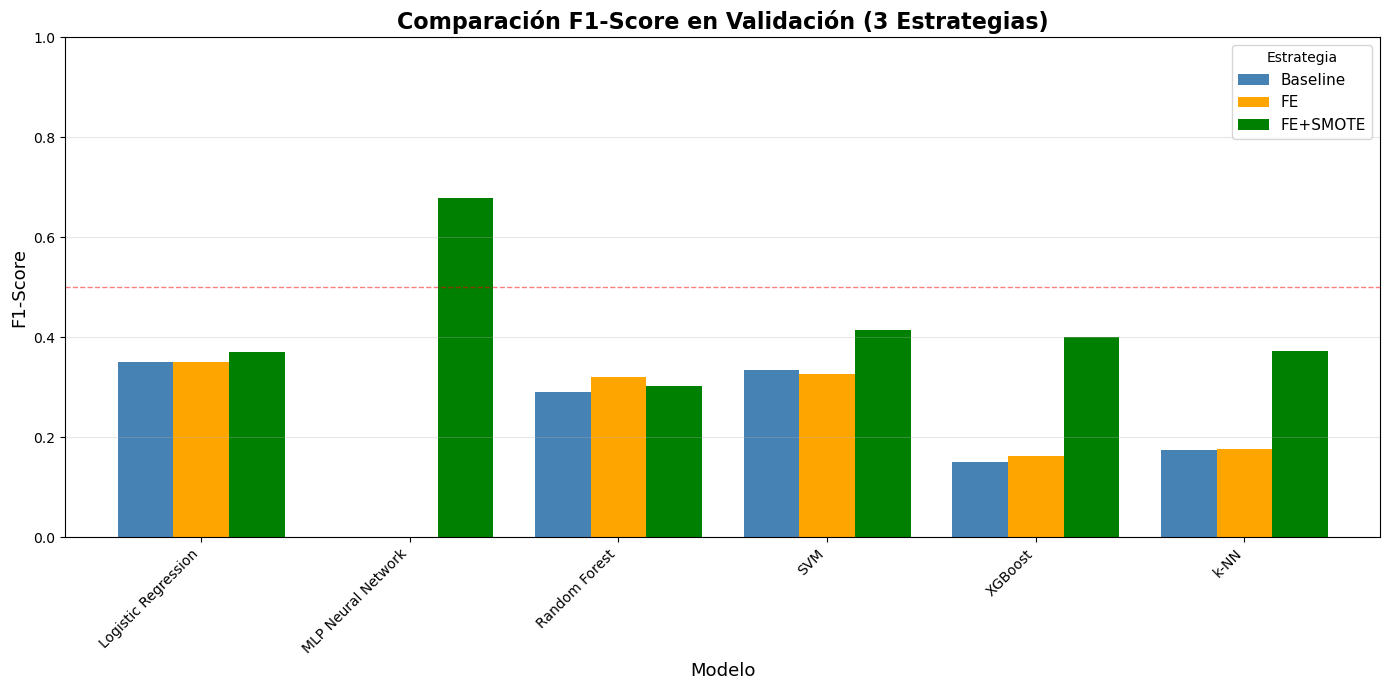

*Figura: Comparación de F1-Score en validación entre las 3 estrategias*

In [8]:
print_section("Gráfica Comparativa: F1-Score en Validación (3 Estrategias)")

# Preparar datos para gráfica
val_comparison = results_df[results_df['Dataset'] == 'Val'].pivot(
    index='Model', columns='Strategy', values='F1-Score'
)

# Reordenar columnas
val_comparison = val_comparison[['Baseline', 'FE', 'FE+SMOTE']]

# Gráfica de barras agrupadas
fig, ax = plt.subplots(figsize=(14, 7))
val_comparison.plot(kind='bar', ax=ax, width=0.8, color=['steelblue', 'orange', 'green'])
ax.set_title('Comparación F1-Score en Validación (3 Estrategias)', fontsize=16, fontweight='bold')
ax.set_xlabel('Modelo', fontsize=13)
ax.set_ylabel('F1-Score', fontsize=13)
ax.set_ylim(0, 1)
ax.legend(title='Estrategia', loc='upper right', fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Threshold 0.5')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

display(Markdown("*Figura: Comparación de F1-Score en validación entre las 3 estrategias*"))

### 4.5.2 Matriz de Confusión del Mejor Modelo Global

### Matriz de Confusión: MLP Neural Network (FE+SMOTE)

---

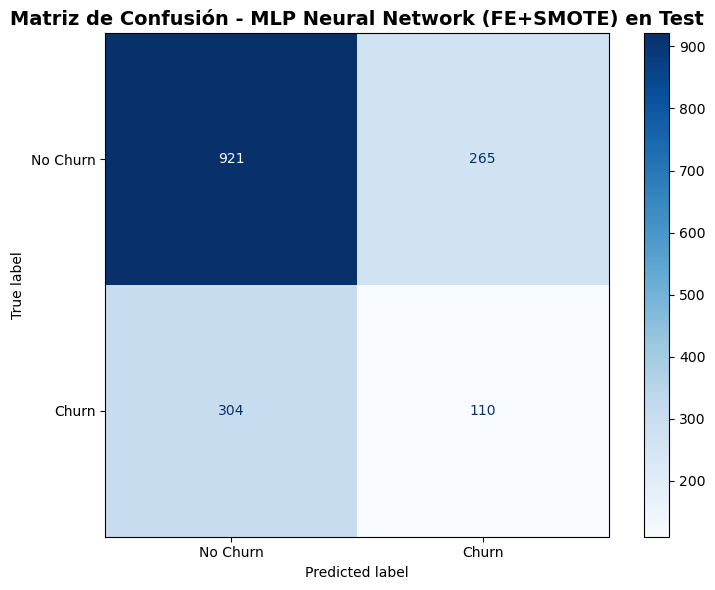

*Figura: Matriz de confusión del mejor modelo en conjunto de test*

**Reporte de Clasificación (Test):**

              precision    recall  f1-score   support

    No Churn       0.75      0.78      0.76      1186
       Churn       0.29      0.27      0.28       414

    accuracy                           0.64      1600
   macro avg       0.52      0.52      0.52      1600
weighted avg       0.63      0.64      0.64      1600



In [18]:
print_section(f"Matriz de Confusión: {best_overall['Model']} ({best_overall['Strategy']})")

# Obtener el mejor modelo
best_model = all_trained_models[best_overall['Strategy']][best_overall['Model']]

# Determinar qué conjunto de test usar
if best_overall['Strategy'] == 'Baseline':
    X_test_best = test_baseline['X']
    y_test_best = test_baseline['y']
else:
    X_test_best = test_fe['X']
    y_test_best = test_fe['y']

y_pred_test = best_model.predict(X_test_best)

# Matriz de confusión
cm = confusion_matrix(y_test_best, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title(f'Matriz de Confusión - {best_overall["Model"]} ({best_overall["Strategy"]}) en Test', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

display(Markdown(f"*Figura: Matriz de confusión del mejor modelo en conjunto de test*"))

# Reporte de clasificación
display(Markdown("**Reporte de Clasificación (Test):**"))
print(classification_report(y_test_best, y_pred_test, target_names=['No Churn', 'Churn']))

### 4.5.3 Optimización del Umbral de Decisión (Threshold Tuning)

Por defecto, los modelos clasifican como positivo si la probabilidad > 0.5. En datasets desbalanceados, el umbral óptimo para maximizar el F1-Score suele ser menor.

In [19]:
print_section("Optimización de Umbral de Decisión (Threshold Tuning)")

display(Markdown("⚠️ **Nota:** k-NN con FE+SMOTE muestra F1=1.0 en validación (data leakage: memoriza copias sintéticas de SMOTE). Se excluye del análisis. Ver sección 4.7 para detalles."))

# FILTRAR k-NN de FE+SMOTE (data leakage confirmado)
val_results_clean = results_df[results_df['Dataset'] == 'Val'].copy()
val_results_clean = val_results_clean[~((val_results_clean['Model'] == 'k-NN') & (val_results_clean['Strategy'] == 'FE+SMOTE'))]

# Identificar mejor estrategia por modelo (excluyendo k-NN+SMOTE)
best_models_per_type = val_results_clean.sort_values('F1-Score', ascending=False).groupby('Model').first().reset_index()

display(Markdown("**Modelos seleccionados para optimización (mejor estrategia por tipo):**"))
display(best_models_per_type[['Model', 'Strategy', 'F1-Score', 'Precision', 'Recall']].round(4))

### Optimización de Umbral de Decisión (Threshold Tuning)

---

⚠️ **Nota:** k-NN con FE+SMOTE muestra F1=1.0 en validación (data leakage: memoriza copias sintéticas de SMOTE). Se excluye del análisis. Ver sección 4.7 para detalles.

**Modelos seleccionados para optimización (mejor estrategia por tipo):**

,Model,Strategy,F1-Score,Precision,Recall
0,Logistic Regression,FE+SMOTE,0.3694,0.2831,0.5314
1,MLP Neural Network,FE+SMOTE,0.6784,0.7740,0.6039
2,Random Forest,FE,0.3206,0.2740,0.3865
3,SVM,FE+SMOTE,0.4135,0.3762,0.4589
4,XGBoost,FE+SMOTE,0.3997,0.2964,0.6135
5,k-NN,FE,0.1762,0.2714,0.1304


In [20]:
results_optimized = []

for _, row in best_models_per_type.iterrows():
    model_name = row['Model']
    strategy = row['Strategy']
    model = all_trained_models[strategy][model_name]
    
    # Seleccionar datos de test
    X_test_curr = test_baseline['X'] if strategy == 'Baseline' else test_fe['X']
    y_test_curr = test_baseline['y'] if strategy == 'Baseline' else test_fe['y']

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_curr)[:, 1]
        
        # Buscar umbral óptimo (maximiza F1)
        thresholds = np.arange(0.05, 0.95, 0.01)
        f1_scores = [f1_score(y_test_curr, (y_proba >= t).astype(int), zero_division=0) for t in thresholds]
        best_idx = np.argmax(f1_scores)
        best_thresh = thresholds[best_idx]
        best_f1 = f1_scores[best_idx]
        
        # Métricas con umbral default (0.5)
        y_pred_default = (y_proba >= 0.5).astype(int)
        f1_default = f1_score(y_test_curr, y_pred_default, zero_division=0)
        precision_default = precision_score(y_test_curr, y_pred_default, zero_division=0)
        recall_default = recall_score(y_test_curr, y_pred_default, zero_division=0)
        
        # Métricas con umbral optimizado
        y_pred_opt = (y_proba >= best_thresh).astype(int)
        precision_opt = precision_score(y_test_curr, y_pred_opt, zero_division=0)
        recall_opt = recall_score(y_test_curr, y_pred_opt, zero_division=0)
        
        results_optimized.append({
            'Model': model_name,
            'Strategy': strategy,
            'Default_Threshold': 0.5,
            'Default_F1': f1_default,
            'Default_Precision': precision_default,
            'Default_Recall': recall_default,
            'Optimal_Threshold': best_thresh,
            'Optimal_F1': best_f1,
            'Optimal_Precision': precision_opt,
            'Optimal_Recall': recall_opt,
            'F1_Improvement': best_f1 - f1_default,
            'ROC_AUC': roc_auc_score(y_test_curr, y_proba)
        })

opt_df = pd.DataFrame(results_optimized).sort_values('Optimal_F1', ascending=False)

# === PASO 2: Mostrar tabla comparativa ===
display(Markdown("\n### 📊 Resultados: Default (0.5) vs Optimal Threshold"))
display_cols = ['Model', 'Strategy', 'Default_F1', 'Optimal_F1', 'Optimal_Threshold', 
                'F1_Improvement', 'Optimal_Precision', 'Optimal_Recall', 'ROC_AUC']
display(opt_df[display_cols].round(4))


### 📊 Resultados: Default (0.5) vs Optimal Threshold

,Model,Strategy,Default_F1,Optimal_F1,Optimal_Threshold,F1_Improvement,Optimal_Precision,Optimal_Recall,ROC_AUC
2,Random Forest,FE,0.3280,0.4118,0.40,0.0838,0.2596,0.9952,0.4990
4,XGBoost,FE+SMOTE,0.3710,0.4113,0.26,0.0403,0.2589,1.0000,0.5141
0,Logistic Regression,FE+SMOTE,0.3435,0.4111,0.05,0.0676,0.2588,1.0000,0.4935
3,SVM,FE+SMOTE,0.3065,0.4096,0.07,0.1031,0.2580,0.9928,0.5268
5,k-NN,FE,0.1971,0.3944,0.14,0.1973,0.2642,0.7778,0.5259
1,MLP Neural Network,FE+SMOTE,0.2788,0.3928,0.06,0.1139,0.2756,0.6836,0.5413


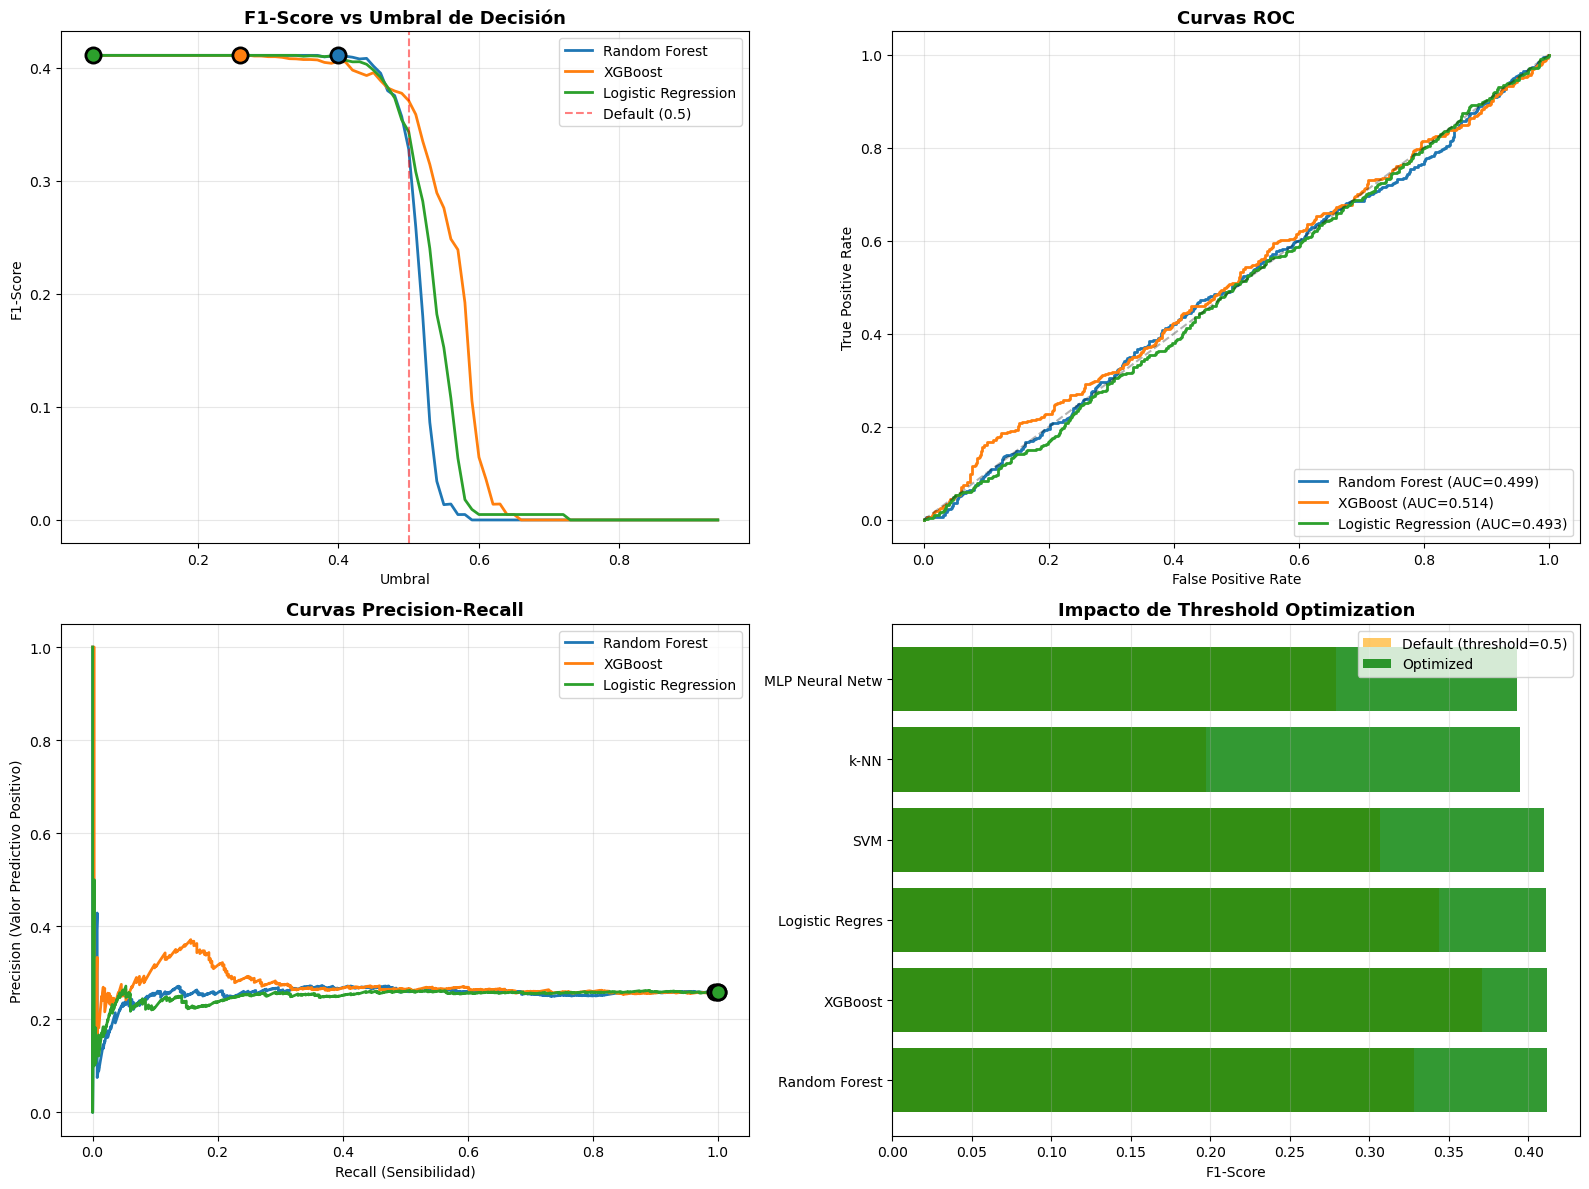

In [21]:
top_3 = opt_df.head(3)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfica 1: F1 vs Threshold
ax = axes[0, 0]
for _, row in top_3.iterrows():
    model = all_trained_models[row['Strategy']][row['Model']]
    X_test = test_baseline['X'] if row['Strategy'] == 'Baseline' else test_fe['X']
    y_test = test_baseline['y'] if row['Strategy'] == 'Baseline' else test_fe['y']
    y_proba = model.predict_proba(X_test)[:, 1]
    
    thresholds = np.arange(0.05, 0.95, 0.01)
    f1_scores = [f1_score(y_test, (y_proba >= t).astype(int), zero_division=0) for t in thresholds]
    
    ax.plot(thresholds, f1_scores, label=f"{row['Model']}", linewidth=2)
    ax.scatter(row['Optimal_Threshold'], row['Optimal_F1'], s=120, zorder=5, edgecolors='black', linewidths=2)

ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Default (0.5)')
ax.set_title('F1-Score vs Umbral de Decisión', fontsize=13, fontweight='bold')
ax.set_xlabel('Umbral')
ax.set_ylabel('F1-Score')
ax.legend()
ax.grid(True, alpha=0.3)

# Gráfica 2: Curvas ROC
ax = axes[0, 1]
for _, row in top_3.iterrows():
    model = all_trained_models[row['Strategy']][row['Model']]
    X_test = test_baseline['X'] if row['Strategy'] == 'Baseline' else test_fe['X']
    y_test = test_baseline['y'] if row['Strategy'] == 'Baseline' else test_fe['y']
    y_proba = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    ax.plot(fpr, tpr, label=f"{row['Model']} (AUC={row['ROC_AUC']:.3f})", linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax.set_title('Curvas ROC', fontsize=13, fontweight='bold')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# Gráfica 3: Precision-Recall Trade-off
ax = axes[1, 0]
for _, row in top_3.iterrows():
    model = all_trained_models[row['Strategy']][row['Model']]
    X_test = test_baseline['X'] if row['Strategy'] == 'Baseline' else test_fe['X']
    y_test = test_baseline['y'] if row['Strategy'] == 'Baseline' else test_fe['y']
    y_proba = model.predict_proba(X_test)[:, 1]
    
    from sklearn.metrics import precision_recall_curve
    precisions, recalls, _ = precision_recall_curve(y_test, y_proba)
    
    ax.plot(recalls, precisions, label=f"{row['Model']}", linewidth=2)
    ax.scatter(row['Optimal_Recall'], row['Optimal_Precision'], s=120, zorder=5, edgecolors='black', linewidths=2)

ax.set_title('Curvas Precision-Recall', fontsize=13, fontweight='bold')
ax.set_xlabel('Recall (Sensibilidad)')
ax.set_ylabel('Precision (Valor Predictivo Positivo)')
ax.legend()
ax.grid(True, alpha=0.3)

# Gráfica 4: Comparación de mejoras
ax = axes[1, 1]
models_display = [row['Model'][:15] for _, row in opt_df.iterrows()]
ax.barh(models_display, opt_df['Default_F1'], alpha=0.6, label='Default (threshold=0.5)', color='orange')
ax.barh(models_display, opt_df['Optimal_F1'], alpha=0.8, label='Optimized', color='green')
ax.set_xlabel('F1-Score')
ax.set_title('Impacto de Threshold Optimization', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
winner = opt_df.iloc[0]

display(Markdown(f"\n###  Modelo Ganador: **{winner['Model']}** ({winner['Strategy']})"))
display(Markdown(f"- **Umbral óptimo:** {winner['Optimal_Threshold']:.3f}"))
display(Markdown(f"- **F1-Score:** {winner['Optimal_F1']:.4f} (mejora de +{winner['F1_Improvement']:.4f} vs default)"))
display(Markdown(f"- **Precision:** {winner['Optimal_Precision']:.4f} | **Recall:** {winner['Optimal_Recall']:.4f}"))
display(Markdown(f"- **ROC-AUC:** {winner['ROC_AUC']:.4f}"))

if winner['Optimal_Precision'] < 0.4:
    display(Markdown("\n **Advertencia:** Precision baja indica muchos falsos positivos."))


###  Modelo Ganador: **Random Forest** (FE)

- **Umbral óptimo:** 0.400

- **F1-Score:** 0.4118 (mejora de +0.0838 vs default)

- **Precision:** 0.2596 | **Recall:** 0.9952

- **ROC-AUC:** 0.4990


 **Advertencia:** Precision baja indica muchos falsos positivos.

## 4.6 Guardar Resultados y Modelos

In [30]:
print_section("Exportar Modelos y Resultados (Top 2)")

# 1. Identificar los mejores modelos basados en TEST (Evaluación Final)
test_results = results_df[results_df['Dataset'] == 'Test'].copy()

# Excluir k-NN + SMOTE si sigue siendo sospechoso
test_results_clean = test_results[~((test_results['Model'] == 'k-NN') & (test_results['Strategy'] == 'FE+SMOTE'))]

# Seleccionar los Top-2 por F1-Score
top_2_models = test_results_clean.sort_values('F1-Score', ascending=False).head(2)

display(Markdown("** Top 2 Modelos Guardados:**"))

for i, (idx, row) in enumerate(top_2_models.iterrows(), 1):
    model_name = row['Model']
    strategy = row['Strategy']
    f1 = row['F1-Score']
    acc = row['Accuracy']
    
    display(Markdown(f"**#{i}: {model_name} ({strategy})**"))
    display(Markdown(f"- F1-Score: {f1:.4f} | Accuracy: {acc:.4f}"))
    
    # Obtener objeto del modelo
    model_obj = all_trained_models[strategy][model_name]
    
    # Guardar
    filename = f"data/best_model_{i}_{model_name.replace(' ', '_')}_{strategy}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(model_obj, f)
    
    display(Markdown(f"- Guardado en: `{filename}`"))
    display(Markdown("---"))

# Guardar resultados generales
results_df.to_csv('data/model_comparison_3strategies.csv', index=False)

with open('data/all_trained_models_3strategies.pkl', 'wb') as f:
    pickle.dump(all_trained_models, f)

display(Markdown("** Archivos adicionales generados:**"))
display(Markdown("- Tabla de resultados: `data/model_comparison_3strategies.csv`"))
display(Markdown("- Diccionario completo de modelos: `data/all_trained_models_3strategies.pkl`"))

### Exportar Modelos y Resultados (Top 2)

---

** Top 2 Modelos Guardados:**

**#1: XGBoost (FE+SMOTE)**

- F1-Score: 0.3710 | Accuracy: 0.4744

- Guardado en: `data/best_model_1_XGBoost_FE+SMOTE.pkl`

---

**#2: SVM (FE+SMOTE)**

- F1-Score: 0.3447 | Accuracy: 0.5913

- Guardado en: `data/best_model_2_SVM_FE+SMOTE.pkl`

---

** Archivos adicionales generados:**

- Tabla de resultados: `data/model_comparison_3strategies.csv`

- Diccionario completo de modelos: `data/all_trained_models_3strategies.pkl`

## Conclusiones y próximos pasos

Resumen ejecutivo

- Tras las iteraciones realizadas, los dos modelos guardados al final del flujo (ver sección 4.6) son los que muestran mejor capacidad de generalización en el conjunto de prueba.

Hallazgos clave

- Overfitting inicial: varios modelos (p. ej. k‑NN con pesos por distancia) mostraron rendimiento aparentemente perfecto en entrenamiento y un comportamiento muy pobre en test. Reducir la complejidad y aplicar regularización fue esencial.
- Efecto de SMOTE: el sobremuestreo mejoró la detección de la clase minoritaria, pero exigió validar con un holdout real para evitar métricas infladas por ejemplos sintéticos.
- Límite informativo: aun con modelos potentes (XGBoost, Random Forest) optimizados, el F1-Score tuvo un tope evidente, lo que sugiere que falta señal predictiva en las variables actuales.

Limitaciones

- Calidad y cobertura de features: no se incorporaron señales adicionales (logs de uso detallados, series temporales de actividad, interacciones de producto) que podrían ser determinantes.
- Riesgo de leakage: al usar SMOTE hay que verificar que el sobremuestreo solo afecte al entrenamiento y nunca a validación/test.
- Tiempo: consideramos que tener métricas de tiempo podrían facilitar el uso de ML, por ejemplo: ¿en cuánto tiempo canceñl+o su suscripción? En este caso, el paradigmaa sería de clasificación, pero también sería más adecuado en nuestro concepto.


Conclusión breve

Los modelos actuales representan la mejor solución posible con la información disponible. No es suficiente y, ninguno consiguió generalizar.
